In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import random
import csv
from datetime import datetime

from langchain.schema.runnable import RunnableSequence

In [2]:
# Do imports for squad_scoring and prompts
from pathlib import Path

utils_folder = Path("..")
sys.path.append(str(utils_folder))

utils_folder = Path("../src/deh")
sys.path.append(str(utils_folder))

utils_folder = Path(".")
sys.path.append(str(utils_folder))

import squad_scoring
import deh_prompts
import deh_vector_store
import deh_squad_data
import deh_hyde
from deh_llm import get_llm

##### Set Global variables

In [ ]:
# # Folders for storing data and the results
DATA_ROOT = "../../../deh_data_results/data"         # Set to your own data folder
RESULTS_ROOT = "../../../deh_data_results/results"   # Set to your own results folder
HYDE_BASED_CONTEXTS_ROOT = F"{DATA_ROOT}/hyde_based_contexts"   # Set to your own results folder

# SQuAD dataset
data_file = f"{DATA_ROOT}/dev-v2.0.json"
dataset = squad_scoring.load_dataset(data_file)

# # Vector Store Parameters
VECTOR_STORE_TOP_K = 5
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 100
DEFAULT_CHROMA_PREFIX = "deh_rag"
DEFAULT_CHROMA_COLLECTION = "per_article"
CHUNK_SQUAD_DATASET = False        # Set to True to vectorize the squad dataset. If False, 
                                   # then the documents and their embeddings should already
                                   # exist in the vector store.

# # CONTEXT Creation Parameters
REFRESH_QUESTION_CONTEXTS = False   # Set to True to create question contexts from the vector store; 
                                    # if False, the question contexts are loaded from a csv file.
REFRESH_HYDE_CONTEXTS = False       # Set to True to create hyde contexts; if False,
#                                   # the hyde contexts are loaded from a csv file.                                    

READ_QAS_FROM_FILE = True

# # Bootstrap Parameters
SAMPLE_SIZE = 100
BOOTSTRAPS_N = 10000
# #TODO check if this code is ok for setting the seed
# # SEED = 42
# # set_seed = random.seed(SEED)

# PERSIST_ANSWER_SAMPLES = False   # Set to True to persist the llm answers for each sample, for each experiment


##### Load the SQuAD Dataset

In [4]:
csv_file_path = f"{DATA_ROOT}/qas_with_contexts.csv"

# load the squad data to initialize articles, contexts, qas_with_duplicates, qas, unique_questions
# note that qas may be overwritten in the next statement, if READ_QAS_FROM_FILE is True
print(f"Loading squad data...")
articles, contexts, qas_with_duplicates, qas, unique_questions = deh_squad_data.load_squad_data()

if READ_QAS_FROM_FILE: 
    print(f"Reading qas and contexts from a csv file...")
    
    # Read the qas dataset (including contexts) from a CSV file
    qas = []

    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        
        for i, row in enumerate(csv_reader):
            if i == 0:
                continue
            qas.append({"title": row[0], "context": row[1], "qid": row[2], "question": row[3], "is_impossible": row[4], 
                        "answer": row[5], "hyde_article": row[6], "hyde_based_context": row[7], "question_context": row[8]})
            
            

Loading squad data...
#articles in the dataset:     35
#contexts in the dataset:   1204
#questions in the dataset: 26232
#unique questions in the dataset: 11849
#unique qas in the dataset: 16209
Reading qas and contexts from a csv file...


##### Intialize the Vector Store (Chroma; Milvus not yet included)

In [6]:
if CHUNK_SQUAD_DATASET:    
    deh_vector_store.chunk_squad_dataset(contexts, dataset, CHUNK_SIZE, CHUNK_OVERLAP)
else:
    print("Chunking not foreseen. Skipping chunking.")

Chunking not foreseen. Skipping chunking.


In [7]:
# Intiialize the Chroma vector store
vector_store = deh_vector_store.get_vector_store(DEFAULT_CHROMA_PREFIX, DEFAULT_CHROMA_COLLECTION)

##### Get hyde-based contexts

Always get hyde-based contexts that already exist and these to the qas dataset

In [8]:
if not READ_QAS_FROM_FILE:
    hyde_based_context_path = f"{HYDE_BASED_CONTEXTS_ROOT}/hyde_based_contexts.csv"
    hyde_based_contexts, questions_already_processed = deh_hyde.get_hyde_based_contexts(hyde_based_context_path)
    print(f"Number of questions with hyde-based context: {len(questions_already_processed)}")

In [9]:
if not READ_QAS_FROM_FILE:
    # Now add the hyde-based contexts to the qas dataset
    def get_hyde_based_info_from_qid(qid):
        for hbc in hyde_based_contexts:
            if hbc["qid"] == qid:
                return (hbc["hyde_article"], hbc["hyde_based_context"])
        return ("", "")

    for qa in qas:
        qid = qa["qid"]
        hyde_article, hyde_based_context = get_hyde_based_info_from_qid(qid)
        qa["hyde_article"] = hyde_article
        qa["hyde_based_context"] = hyde_based_context


##### Normal (i.e. not hyde-based) Question Contexts

Questions:

- if configured, either: generate normal question contexts and then persist
- or: read the question contexts from a .csv file


In [10]:
def persist_question_contexts(qas, csv_file_path):

    # Write the the qas dataset including the question contexts to a CSV file
    with open(csv_file_path, mode="w", newline="", encoding="utf-8") as file:
        fieldnames = ["title", "context", "qid", "question", "is_impossible",
                      "answer", "hyde_article", "hyde_based_context", "question_context"]
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()   # Write the header row
        writer.writerows(qas)  # Write the data rows

    print(f"Data successfully written to {csv_file_path}")


In [11]:
# Refresh question contexts (normal contexts and hyde-based contexts)
if REFRESH_QUESTION_CONTEXTS or REFRESH_HYDE_CONTEXTS:
    print(f"Generating question contexts for the dataset and persisting these in a csv file...")

    for i, qa in enumerate(qas):
        if i %100 == 0:
            print(f"Processing question {i}...")

        if REFRESH_QUESTION_CONTEXTS:
            question = qa["question"]
            
            top_docs = vector_store.similarity_search(
                query = question,
                k = VECTOR_STORE_TOP_K,
            )
            qa["question_context"] = " ".join([top_doc.page_content for top_doc in top_docs])

        if REFRESH_HYDE_CONTEXTS:
            hyde_article = qa["hyde_article"]
            if len(hyde_article) > 0:
                #print(f"hyde_article: {hyde_article}")
                top_docs = vector_store.similarity_search(
                    query = hyde_article,
                    k = VECTOR_STORE_TOP_K,
                )

                qa["hyde_based_context"] = " ".join([top_doc.page_content for top_doc in top_docs])

    persist_question_contexts(qas, csv_file_path)



##### Define functions that are needed for experiments

In [12]:
# Create the runnable chain
def get_runnable_chain(current_query_prompt, llm):
    runnable_chain = RunnableSequence(current_query_prompt | llm)
    return runnable_chain

In [13]:
# Get the Hyde context for a question
# Could be made much more efficient by creating a dictionary of hyde contexts
def get_hyde_context(question):
    for qa in qas:
        if qa["question"] == question:
            return qa["hyde_based_context"]
    return None

In [14]:
# generate the LLM answers, using a runnable chain and the sample of questions provided
def generate_llm_answers(runnable_chain, qas_sample, hyde=False):
    
    preds = {}

    sample_size = len(qas_sample)
    print(f"sample_size: {sample_size}")

    for i, qa in enumerate(qas_sample):

        question = qa["question"]
        if hyde:
            #context = qa["hyde_context"]
            context = get_hyde_context(question)
        else:
            context = qa["vector_store_context"]
            
        # print(f"question --> {question}")
        # print(context)
        response = runnable_chain.invoke({"context": context, "question": question})
                
        qid = squad_scoring.get_qid_from_question(question, dataset)
        
        if response.content.upper() == "DONT KNOW":
            llm_answer = ""
        else:
            llm_answer = response.content

        preds[qid] = llm_answer
        qas_sample[i]["llm_answer"] = llm_answer

    return preds


In [15]:
#%%capture

# Get the metrics for a set of predictions (preds) that have been generated in a run
def get_squad_metrics(dataset, preds, verbose=False):
    squad_metrics = squad_scoring.calc_squad_metrics(dataset, preds);
    return squad_metrics["precision"], squad_metrics["recall"], squad_metrics["f1"]


In [16]:
# Calculate the mean and confidence interval for a list of scores
# TODO: Check if this is calculation is correct !!
def calculate_mean_confidence_interval(scores_l):

    # Calculate mean
    mean = np.mean(scores_l)

    # Calculate 95% confidence interval
    sample_std_dev = np.std(scores_l, ddof=1)
    margin_of_error = 1.96 * sample_std_dev
    ci = (mean - margin_of_error, mean + margin_of_error)

    return mean, ci

In [17]:
# Generate a histogram for a list of scores and persist it
def generate_histogram(scores_l, mean, ci, results_folder_name, experiment_name):

    plt.clf
    plt.hist(scores_l, bins=30, density=False, edgecolor='black', alpha=0.6, color = 'lightblue' ) # color='aquamarine')
    plt.xlim(0, 100)
    plt.title(f"F1-Scores for {experiment_name} - (Bootstraps: {BOOTSTRAPS_N} - Sample Size: {SAMPLE_SIZE})", fontsize=10)
    plt.xlabel("F1-Score")
    plt.ylabel("Frequency")

    # Add a vertical line for the mean
    plt.axvline(mean, color='red', linestyle='dotted', linewidth=2, label=f'Mean F1: {round(mean, 2)}')

    # Add vertical lines for the 95% confidence interval
    plt.axvline(ci[0], color='orange', linestyle='dashdot', linewidth=1.5, label='95% CI Lower')
    plt.axvline(ci[1], color='orange', linestyle='dashdot', linewidth=1.5, label='95% CI Upper')

    plt.legend(loc='upper right', fontsize=10)
    plt.savefig(os.path.join(results_folder_name, f"{experiment_name}_{BOOTSTRAPS_N}_{SAMPLE_SIZE}"))

##### Define functions for Bootstrapping

In [18]:
# Get the current timestamp and format the start timestamp as a string
def get_timestamp_as_string():
    start_timestamp = datetime.now()
    start_timestamp_str = start_timestamp.strftime('%Y%m%d_%H%M%S')
    return start_timestamp_str

In [ ]:
# Adding f1, precision, recall for NO_RAG

def calculate_scores(qas, query_prompt_idx, experiment_name, context_needed=False, suppress_answers=False):

    # Create the chain
    current_query_prompt = deh_prompts.query_prompts[query_prompt_idx]
    print(f"current_query_prompt = {current_query_prompt.template}\n")
    llm = get_llm(current_query_prompt)
    runnable_chain = get_runnable_chain(current_query_prompt, llm)

    # Generate the LLM answers for all questions and calculate per-answer metrics 
    preds = {}
    for i, qa in enumerate(qas):

        if i % 10 == 0:
            print(f"Processing question {i}...")

        qid = qa["qid"]
        question = qa["question"]

        if context_needed:
            if experiment_name == "BASIC_RAG_HYDE":
                context = qa["hyde_based_context"]
            else:
                context = qa["question_context"]
            response = runnable_chain.invoke({"question": question, "context": context})
        else:
            response = runnable_chain.invoke({"question": question})

        llm_answer = response.content

        if llm_answer.upper() == "DONT KNOW":
            if suppress_answers:
                continue
            else:
                llm_answer = ""

        preds[qid] = llm_answer
        scores = squad_scoring.calc_squad_metrics(dataset, preds)
        f1 = scores["f1"]
        precision = scores["precision"]
        recall = scores["recall"]

        preds = {}
        qa[f"{experiment_name.lower()}_llm_answer"] = llm_answer
        qa[f"{experiment_name.lower()}_f1"] = f1
        qa[f"{experiment_name.lower()}_precision"] = precision
        qa[f"{experiment_name.lower()}_recall"] = recall
        

In [20]:
def persist_results(results_folder_name, experiment_name, df):

    # if not os.path.exists(results_folder_name):
    #     os.makedirs(results_folder_name)
    # print(f"results_folder_name: {results_folder_name}")
    df = pd.DataFrame(qas)
    df.to_csv(f"{results_folder_name}/qas_{experiment_name.lower()}_scores.csv", header=True, index=False)

In [21]:
def do_bootstrapping(scores_l, results_folder_name, experiment_name, bootstraps_n = BOOTSTRAPS_N):

    mu_hats = []
    n = len(scores_l)
    #print(f"scores_l: {scores_l}")
    for i in range(bootstraps_n):
        if i % 100 == 0:
            print(f"Processing sample {i}...")
        bootstrap_sample = random.choices(scores_l, k=n) # sample with replacement
        mu_hat = np.mean(bootstrap_sample)
        mu_hats.append(mu_hat)

    bootstraps_mean, ci = calculate_mean_confidence_interval(mu_hats)
    #print(f"mu_hats: {mu_hats}")
    generate_histogram(mu_hats, bootstraps_mean, ci, results_folder_name, experiment_name)

In [22]:
def create_results_folder(experiment_name):
    start_timestamp_str = get_timestamp_as_string()
    results_folder_name = f"{RESULTS_ROOT}/{experiment_name}/results_{start_timestamp_str}"
    if not os.path.exists(results_folder_name):
        os.makedirs(results_folder_name, exist_ok=True)
    return results_folder_name

In [23]:
def conduct_experiment(qas, experiment_name, query_prompt_idx, context_needed=False, suppress_answers=False):

    print(f"============= Creating results folder for {experiment_name} =============")
    results_folder_name = create_results_folder(experiment_name)
    
    print(f"============= Calculating scores for {experiment_name} =============")
    print(f"SAMPLE_SIZE: {SAMPLE_SIZE}")
    calculate_scores(qas, query_prompt_idx, experiment_name, context_needed, suppress_answers)


    print(f"============= Persisting results for {experiment_name} =============")
    df = pd.DataFrame(qas)
    persist_results(results_folder_name, experiment_name, df)

    print(f"\n============= Bootstrapping for {experiment_name} =============")
    print(f"BOOTSTRAPS_N: {BOOTSTRAPS_N}")
    do_bootstrapping(df[f"{experiment_name.lower()}_f1"].dropna().tolist(), results_folder_name, experiment_name, BOOTSTRAPS_N)

##### Creating a sample from qas for bootstrapping and bootstrapping with Hyde (will be used for all experiments)

In [24]:
# Getting qid, question, question_context
qas_for_bootstrapping = [{"qid": qa["qid"], "question": qa["question"], "question_context": qa["question_context"]} for qa in qas]
# Removing duplicates
qas_for_bootstrapping = list({frozenset(item.items()): item for item in qas_for_bootstrapping}.values())
# Taking a sample of size SAMPLE_SIZE
qas_for_bootstrapping = random.sample(qas_for_bootstrapping, SAMPLE_SIZE)
len(qas_for_bootstrapping)

qas_for_hyde_bootstrapping = [{"qid": qa["qid"], "question": qa["question"], "hyde_based_context": qa["hyde_based_context"]} for qa in qas if len(qa["hyde_based_context"]) > 0]
# Removing duplicates
qas_for_hyde_bootstrapping = list({frozenset(item.items()): item for item in qas_for_hyde_bootstrapping}.values())
# Taking a sample of size SAMPLE_SIZE for hyde experiment
qas_for_hyde_bootstrapping = random.sample(qas_for_hyde_bootstrapping, SAMPLE_SIZE)


##### Calculate Resulst for NO_RAG

In [ ]:
conduct_experiment(qas_for_bootstrapping, "NO_RAG", 0, context_needed=False)

##### Calculating scores for BASIC_RAG

In [ ]:
conduct_experiment(qas_for_bootstrapping, "BASIC_RAG", 1, context_needed=True)


##### Calculate results for BASIC_RAG_DONT_LIE

In [ ]:
conduct_experiment(qas_for_bootstrapping, "BASIC_RAG_DONT_LIE", 2, context_needed=True)

##### Caclulation for BASIC_RAG_SUPPRESS_ANSWSERS

In [ ]:
conduct_experiment(qas_for_bootstrapping, "BASIC_RAG_SUPPRESS_ANSWERS", 2, context_needed=True, suppress_answers=True)

##### Calculation for BASIC_RAG_HYDE_ANSWERS

============= Creating results folder for BASIC_RAG_HYDE =============
============= Calculating scores for BASIC_RAG_HYDE =============
SAMPLE_SIZE: 30
current_query_prompt = 
                You are an assistant for question-answering tasks.
                Use the following pieces of retrieved context to answer the question.
                If you don't know the answer, just return 'DONT KNOW'. 
                If you know the answer, keep it as short and concise as possible,
                i.e. to a maximum of a couple of words.

                Question: {question}
                Context: {context}

                Answer:
                

Processing question 0...
taking hyde_based_context
taking hyde_based_context
taking hyde_based_context
taking hyde_based_context
taking hyde_based_context
taking hyde_based_context
taking hyde_based_context
taking hyde_based_context
taking hyde_based_context
taking hyde_based_context
Processing question 10...
taking hyde_based_context
taking 

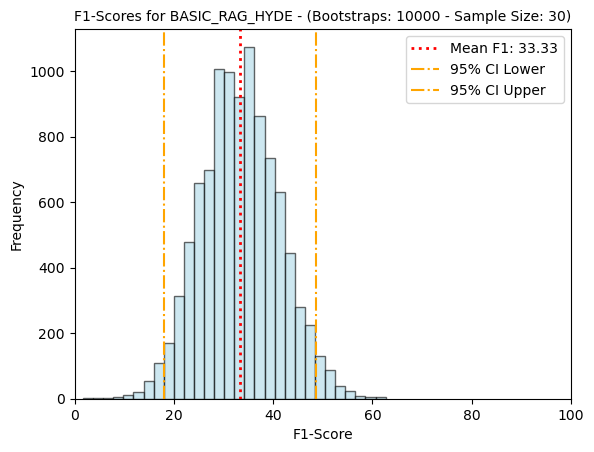

In [25]:
conduct_experiment(qas_for_hyde_bootstrapping, "BASIC_RAG_HYDE", 2, context_needed=True, suppress_answers=False    )